# Per-Image Metrics

How to use, plot, and compare models using per-image [pixel-wise] metrics. 

# Installing Anomalib

The easiest way to install anomalib is to use pip. You can install it from the command line using the following command:


In [1]:
%pip install anomalib

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload

In [3]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Data

We will use MVTec AD DataModule. 

> See [these notebooks](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules) for more details on datamodules. 

We assume that `datasets` directory is created in the `anomalib` root directory and `MVTec` dataset is located in `datasets` directory.

In [4]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded to this directory.
dataset_root = Path.cwd().parent.parent / "datasets" / "MVTec"

We will be working on a segmentation task. 

In [5]:
from anomalib.data import TaskType

task = TaskType.SEGMENTATION

And with the `hazelnut` category at resolution of 256x256 pixels.

In [6]:
from anomalib.data.mvtec import MVTec

datamodule = MVTec(
    root=dataset_root,
    category="hazelnut",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=8,
    task=task,
)
datamodule.setup()
i, data = next(enumerate(datamodule.test_dataloader()))
print(f'Image Shape: {data["image"].shape} Mask Shape: {data["mask"].shape}')

Image Shape: torch.Size([32, 3, 256, 256]) Mask Shape: torch.Size([32, 256, 256])


# Model

We will use PaDiM.

> See [these notebooks](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/200_models) for more details on models. 

The next cell instantiates and trains the model.

The `MetricsConfigurationCallback()` will not have metric because they will be created manually.

In [7]:
from pytorch_lightning import Trainer

from anomalib.utils.callbacks import MetricsConfigurationCallback, PostProcessingConfigurationCallback
from anomalib.post_processing import NormalizationMethod, ThresholdMethod
from anomalib.models import Padim

model = Padim(
    input_size=(256, 256),
    layers=[
        "layer1",
        "layer2",
    ],
    backbone="resnet18",
    pre_trained=True,
)

trainer = Trainer(
    callbacks=[
        PostProcessingConfigurationCallback(
            normalization_method=NormalizationMethod.MIN_MAX,
            threshold_method=ThresholdMethod.ADAPTIVE,
        ),
        MetricsConfigurationCallback(),
    ],
    max_epochs=1,
    num_sanity_val_steps=0,  # does not work for padim
    accelerator="auto",
)

trainer.fit(datamodule=datamodule, model=model)

/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.

Training: 0it [00:00, ?it/s]

/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.10/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


# Process test images

This part is usually happening automatically but here we want to extract the outputs manually.

In [8]:
import torch

model.eval()

outputs = []
for batchidx, batch in enumerate(datamodule.test_dataloader()):
    outputs.append(model.test_step_end(model.test_step(batch, batchidx)))

anomaly_maps = torch.squeeze(torch.cat([o["anomaly_maps"] for o in outputs], dim=0))
masks = torch.squeeze(torch.cat([o["mask"] for o in outputs], dim=0)).int()
print(f"{anomaly_maps.shape=} {masks.shape=}")

Padim(
  (image_threshold): AnomalyScoreThreshold()
  (pixel_threshold): AnomalyScoreThreshold()
  (model): PadimModel(
    (feature_extractor): FeatureExtractor(
      (feature_extractor): FeatureListNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (drop_block): Identity()
            (act1): ReLU(inplace=True)
            (aa): Identity()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2)

anomaly_maps.shape=torch.Size([110, 256, 256]) masks.shape=torch.Size([110, 256, 256])


# Pixel-wise [set] metrics

The usual set pixel-wise metrics. 

Only one value for the whole test set is measured.

/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/jcasagrandebertoldo/miniconda3/envs/anomalib-dev-gsoc/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


AUROC()

AUPR()

AUROC()=0.9811850786209106


(<Figure size 640x480 with 1 Axes>, 'ROC')

AUPR()=0.553596556186676


(<Figure size 640x480 with 1 Axes>, 'AUPR')

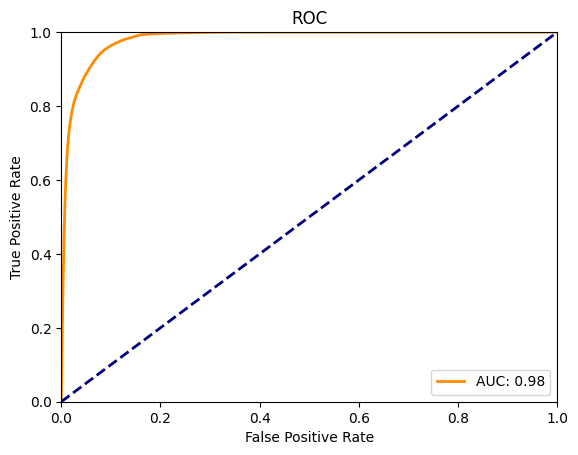

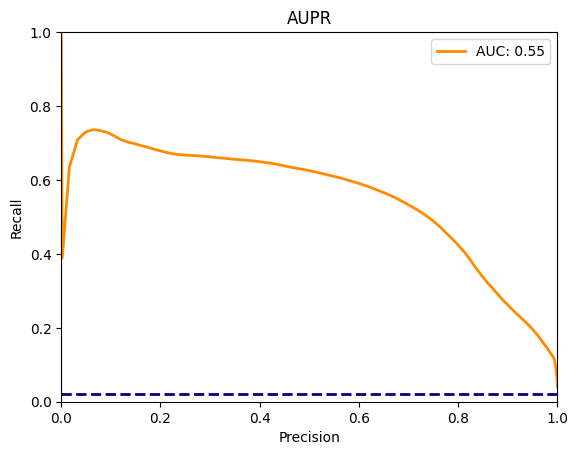

In [9]:
import torch
from anomalib.utils.metrics import AUROC, AUPR

metrics = [AUROC(), AUPR()]

for metric in metrics:
    metric.cpu()
    metric.update(anomaly_maps, masks)

for metric in metrics:
    print(f"{metric}={metric.compute()}")
    metric.generate_figure()

# `AUPImO` (init, update, compute)

Area Under the Per-Image Overlap (`AUPImO`) 

Let's instantiate, load the data, then compute PImO curves and their AUCs (AUPImO scores).

In [10]:
%%time
%autoreload 2

from anomalib.utils.metrics.perimg import AUPImO

aupimo = AUPImO()
aupimo.cpu()
aupimo.update(anomaly_maps, masks)

pimoresult, aucs = aupimo.compute()
(thresholds, fprs, shared_fpr, tprs, image_classes) = pimoresult

/home/jcasagrandebertoldo/repos/anomalib/src/anomalib/utils/metrics/perimg/binclf_curve.py:350: UserWarning: Metric `AUPImO` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(


CPU times: user 2.96 s, sys: 26.1 ms, total: 2.99 s
Wall time: 2.64 s


In [11]:
pimoresult?

Type:        PImOResult
String form:
PImOResult(thresholds=tensor([ 2.4713,  2.4751,  2.4788,  ..., 39.7010, 39.7047, 39.7085]), fprs= <...> 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32))
Length:      5
File:        ~/repos/anomalib/src/anomalib/utils/metrics/perimg/pimo.py
Docstring:  
PImO result (from `PImO.compute()`).

[0] thresholds: shape (num_thresholds,), a `float` dtype as given in update()
[1] fprs: shape (num_images, num_thresholds), dtype `float64`, \in [0, 1]
[2] shared_fpr: shape (num_thresholds,), dtype `float64`, \in [0, 1]
[3] tprs: shape (num_images, num_thresholds), dtype `float64`, \in [0, 1] for anom images, `nan` for norm images
[4] image_classes: shape (num_images,), dtype `int32`, \in {0, 1}

- `num_thresholds` is an attribute of `PImO` and is given in the constructor (from parent class).
- `num_images` depends on the data seen by the model at the update() calls.

In [12]:
print(f"{thresholds.shape=}")
print(f"{fprs.shape=}")
print(f"{shared_fpr.shape=}")
print(f"{tprs.shape=}")
print(f"{image_classes.shape=}")
print(f"{aucs.shape=}")

thresholds.shape=torch.Size([10000])
fprs.shape=torch.Size([110, 10000])
shared_fpr.shape=torch.Size([10000])
tprs.shape=torch.Size([110, 10000])
image_classes.shape=torch.Size([110])
aucs.shape=torch.Size([110])


# `PImO` curves (plot)

The PImO curve has a shared X-axis and a per-image Y-axis.

The X-axis:
- is a metric of False Positives only in the normal images (here it is the set-FPR)
- is shared by all image instances

The Y-axis: 
- is the **overlap** between the binary predicted mask and the ground truth mask, which corresponds to the True Positive Rate (TPR) in a single image
- has one value per image, so there is one PImO curve per image. 

(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Per-Image Overlap Curves'}, xlabel='Mean FPR on Normal Images', ylabel='Per-Image Overlap (in-image TPR)'>)

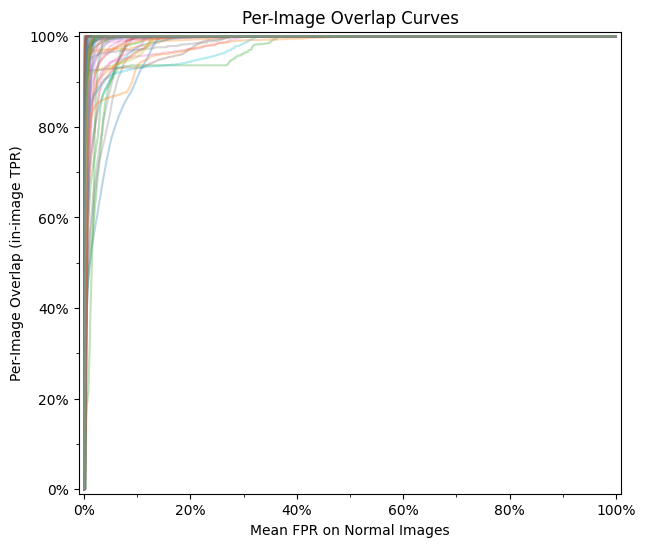

In [13]:
aupimo.plot_all_pimo_curves()
# TODO add functional interface

# `AUPImO` = AUC(`PImO`)

The Area Under the Curve (AUC) is, by consequence, computed for each image, which will be used as is score.

Notice that `aucs` has the number of images seen in `outputs` (cf. `masks` below).

`aucs` has `nan` values for the normal images because the `Per-Image Overlap`, by definition, is not defined on them (they do not have any positive/anomalous pixels).

This is done by design choice so the indexes in `aucs` correspond to the indices of the actual images.

In [14]:
print(f"{masks.shape[0]=}  ==  {aucs.shape[0]=}")
print(aucs)

masks.shape[0]=110  ==  aucs.shape[0]=110
tensor([0.9955, 0.9966, 0.9840, 0.9896, 0.9973, 0.9947, 0.9924, 0.9816, 0.9978,
        0.9849, 0.9693, 0.9927, 0.9651, 0.9859, 0.9928, 0.9847, 0.9944, 0.9772,
        0.9980, 0.9934, 0.9964, 0.9962, 0.9940, 0.9979, 0.9935, 0.9970, 0.9834,
        0.9953, 0.9980, 0.9982, 0.9982, 0.9948, 0.9855, 0.9968, 0.9966,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan, 0.9988, 0.9995, 0.9993, 0.9989, 0.9992, 0.9989,
        0.9893, 1.0000, 0.9984, 0.9986, 0.9979, 0.9897, 0.9915, 0.9974, 0.9778,
        0.9993, 0.9759, 0.9972, 0.9993, 0.9993, 0.9996, 0.9934, 0.9994, 0.9912,
        0.9995, 0.9985, 0.9997, 0.9976, 0.9995, 0.9985, 0.9992, 0.9960, 0.9970

# `AUPImO` distribuion (boxplot)

One can now analyze the distribution of this True Posivity metric across images and take statistics from the test set (e.g. with `sp.stats.describe`).

`AUPImO` has an integrated feature to plot a boxplot from the distribution and inspect representative cases using its statistics.

DescribeResult(nobs=70, minmax=(0.9650637876762534, 0.9999520153194279), mean=0.9937265461888434, variance=5.594496399972953e-05, skewness=-1.9027547256166528, kurtosis=3.391341295957946)


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Area Under the Per-Image Overlap (AUPImO) Boxplot'}, xlabel='AUPImO [%]'>)

[{'statistic': 'med',
  'value': 0.9969119480468276,
  'nearest': 0.99683797565711,
  'imgidx': 33},
 {'statistic': 'q3',
  'value': 0.998546394841429,
  'nearest': 0.9985619360239717,
  'imgidx': 84},
 {'statistic': 'whishi',
  'value': 0.9999520153194279,
  'nearest': 0.9999520153194279,
  'imgidx': 82}]

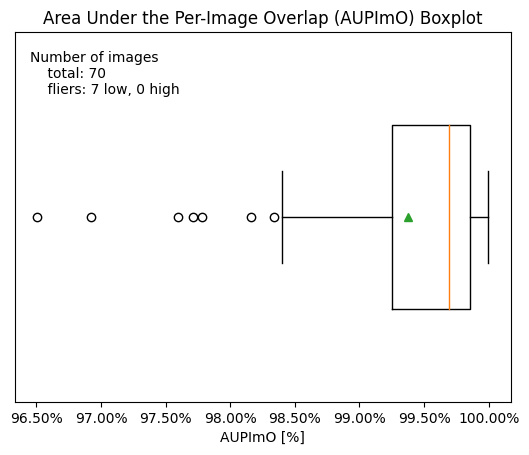

In [15]:
import scipy as sp

print(sp.stats.describe(aucs[~torch.isnan(aucs)]))  # `~torch.isnan(aucs)` is removing the `nan`s
aupimo.plot_boxplot()
aupimo.boxplot_stats()[-3:]
# TODO add functional interface

# Representative samples (curve + boxplot)

The two plots (`PImO` curve + `AUPImO` boxplot) are combined with the method `AUPImO.plot()`.

The `PImO` curves are plot only for the samples that correspond to the boxplot's statistics (see `AUPImO.boxplot_stats()`).

(<Figure size 1400x600 with 2 Axes>,
 array([<Axes: title={'center': 'AUC Boxplot'}, xlabel='AUPImO [%]'>,
        <Axes: title={'center': 'Curves'}, xlabel='Mean FPR on Normal Images', ylabel='Per-Image Overlap (in-image TPR)'>],
       dtype=object))

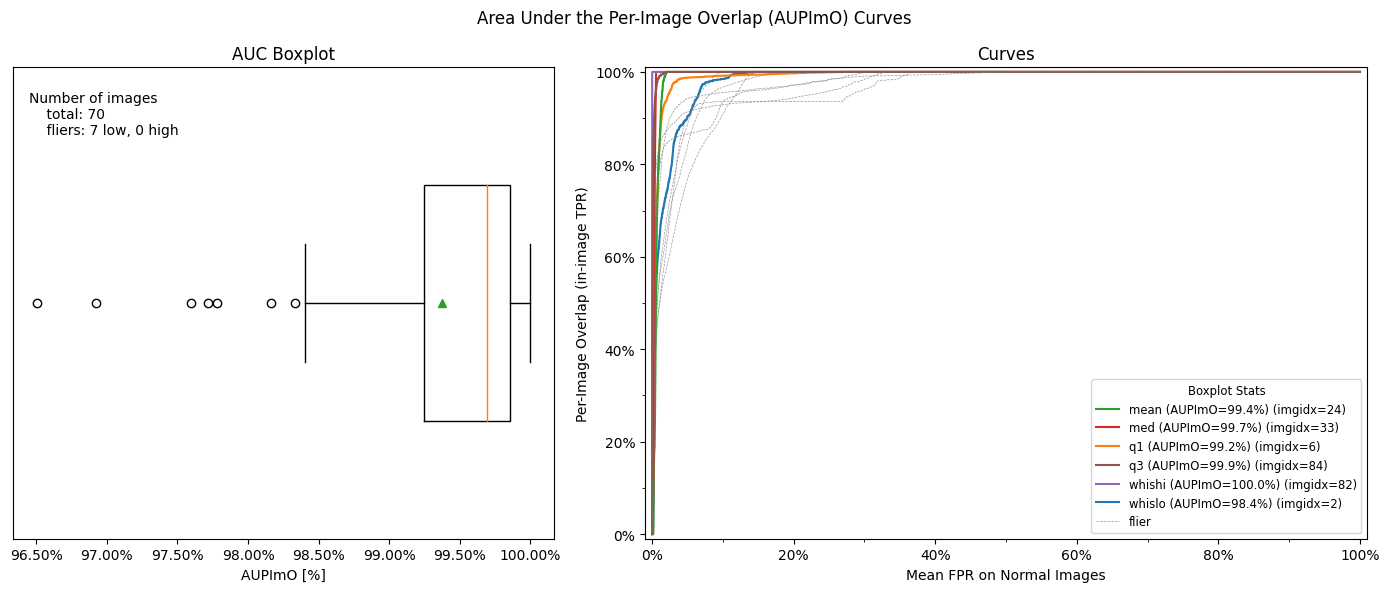

In [16]:
aupimo.plot()

# `AUPImO` with restricted FPR (x-axis) range.

Look at the curve plots (in linear scale, not log).

Most part of the curves are close to `PImO == 1` (i.e. `TPR == 1`) for values of of `FPR >= 30` -- which explains why most of the AUCs are so high.

Notice the AUC of a curve with the x-axis in [0, 1] can be interpreted as the average value of the y-axis.
So the `AUPImO`, like `AUROC` and `AUPRO` (**TODO ADD REFS**), is a true positive metric averaged over many operating points.

On the other hand, the right-most end of the curve coresponds to operating points with high FPR, which is undisarable.

Therefore we add a hard restriction to avoid the high levels of FPR and only do the integration of the curve up to an upper bound of FPR level (`fpr_auc_ubound`); the metric is normalized by the size of the integration range so the AUC metric is scaled in [0, 1].

---

Below, we set the TPR to 3\%.

/home/jcasagrandebertoldo/repos/anomalib/src/anomalib/utils/metrics/perimg/binclf_curve.py:350: UserWarning: Metric `AUPImO` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(


aupimo.ubound=tensor(0.0300, dtype=torch.float64)
CPU times: user 1.65 s, sys: 43.8 ms, total: 1.69 s
Wall time: 1.24 s


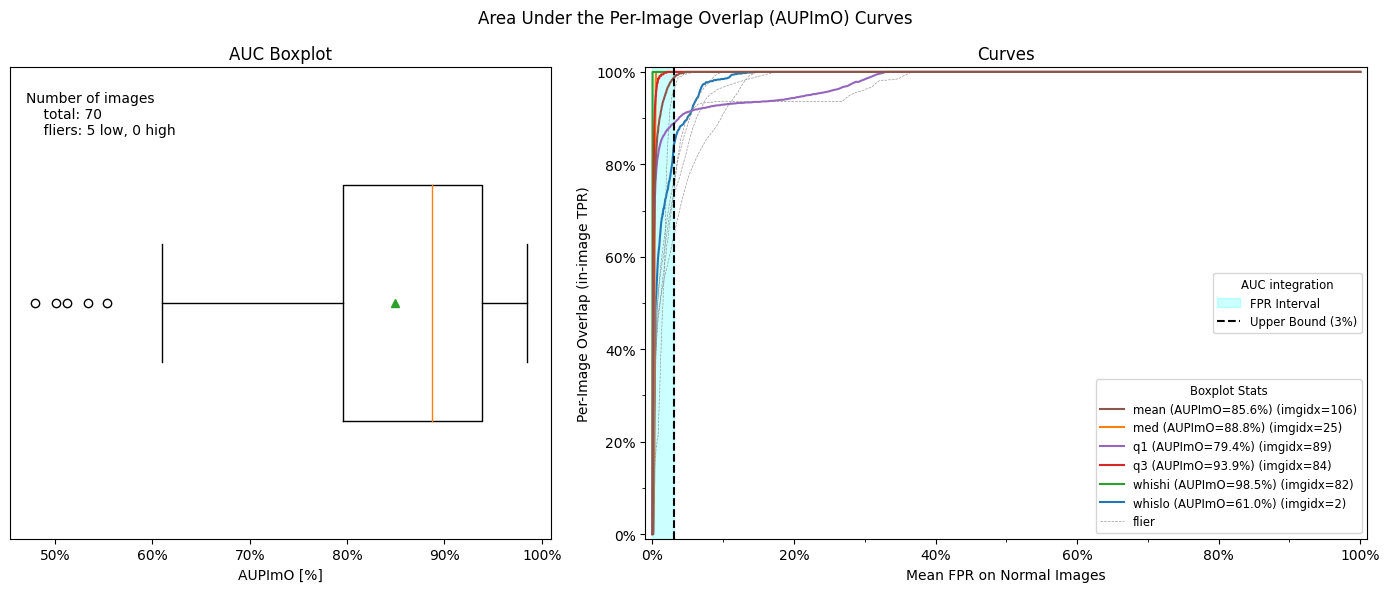

In [17]:
%%time
from anomalib.utils.metrics.perimg import AUPImO

aupimo = AUPImO(num_thresholds=1000, ubound=0.03)
aupimo.cpu()
aupimo.update(anomaly_maps, masks)
pimoresult, aucs = aupimo.compute()
print(f"{aupimo.ubound=}")
fig, ax = aupimo.plot()

# `LogPImO`

Notice (from the boxplot) that most images (~75\%) have an AUC value above 99\%, which makes sense from the curves because they all seem quite close to the upper left corner of the plot.

To make difference between curves more visible, one can put the X-axis (shared FPR) in log scale.


(None,
 <Axes: title={'center': 'Per-Image Overlap Curves'}, xlabel='Mean FPR on Normal Images', ylabel='Per-Image Overlap (in-image TPR)'>)

(None,
 array([<Axes: title={'center': 'AUC Boxplot'}, xlabel='AUPImO [%]'>,
        <Axes: title={'center': 'Curves'}, xlabel='Mean FPR on Normal Images', ylabel='Per-Image Overlap (in-image TPR)'>],
       dtype=object))

(0.0, 1.0, 0.0, 1.0)

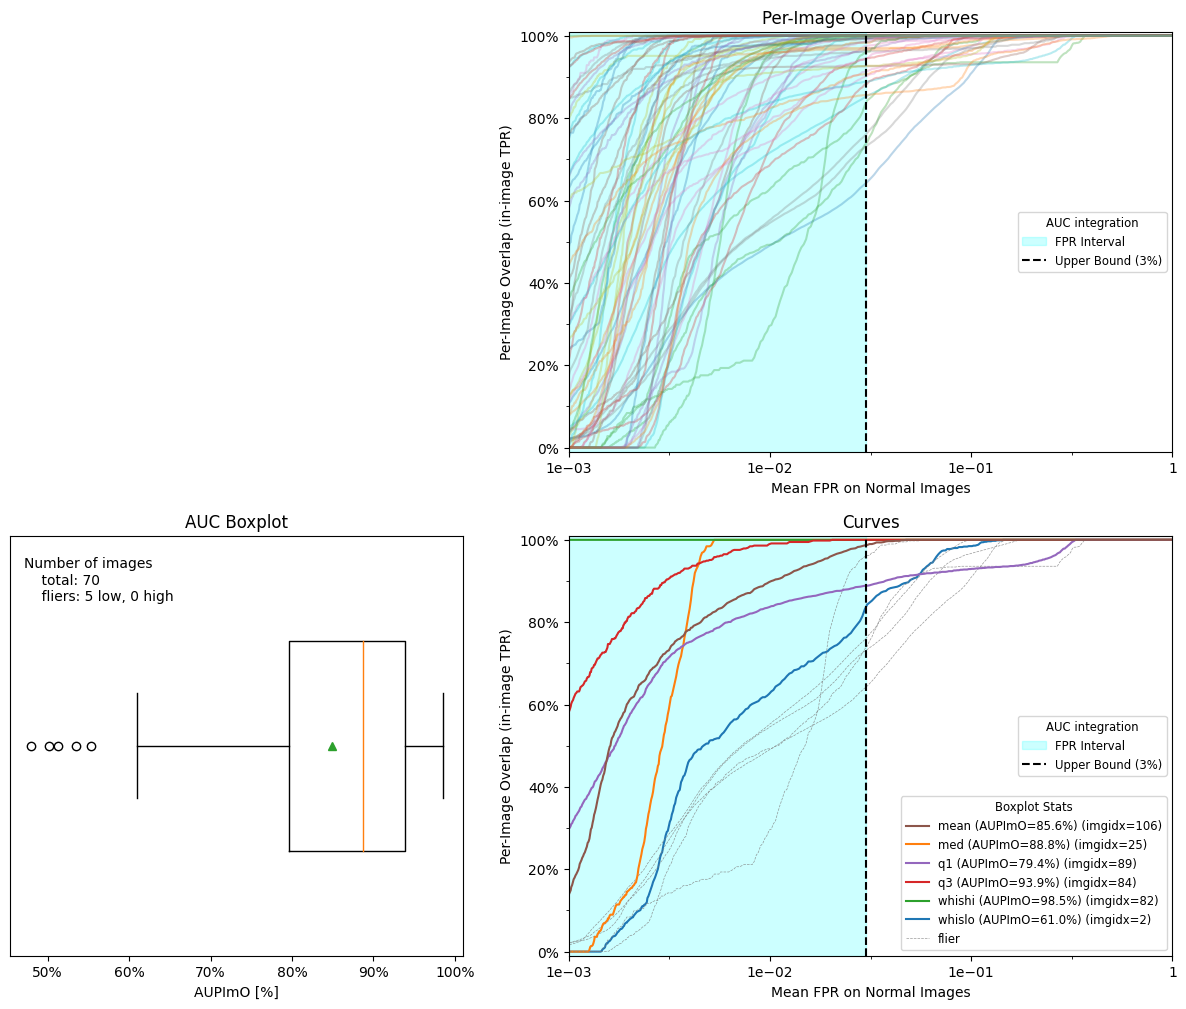

In [18]:
from matplotlib import pyplot as plt
from anomalib.utils.metrics.perimg.plot import _format_axis_rate_metric_log

fig, axes = plt.subplots(2, 2, figsize=(15, 12), width_ratios=[6, 8])
aupimo.plot_all_pimo_curves(ax=axes[0, 1])
aupimo.plot(axes=axes[1])
axes[0, 0].axis("off")
_format_axis_rate_metric_log(axes[0, 1], axis=0)
_format_axis_rate_metric_log(axes[1, 1], axis=0)

# Appendix

## `num_thresholds` parameter

## FPR: Shared vs. Per-Image

The ***shared False Positive Rate (FPR)*** is a central concept. It is the metric used in the x-axis of `PImO`.

Its role is to index the metric of interest -- in this case, the Per-Image Overlap (PImO), a.k.a. the in-image True Positive Rate (TPR).

In other words, the `PImO` curve is a *function of* the the ***shared FPR*** (the independent metric variable).

---

Below we visualize how it is built from the FPR of the individual images and show case useful plotting functions.

In [19]:
from anomalib.utils.metrics.perimg import PImO

pimo = PImO(num_thresholds=1000, fpr_auc_ubound=0.03)
pimo.cpu()
pimo.update(anomaly_maps, masks)

_, fprs, shared_fpr, __, image_classes = pimo.compute()
print(f"{fprs.shape=}\n{shared_fpr.shape=}\n{image_classes.shape=}")

/home/jcasagrandebertoldo/repos/anomalib/src/anomalib/utils/metrics/perimg/binclf_curve.py:350: UserWarning: Metric `PImO` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(


PImO()

fprs.shape=torch.Size([110, 1000])
shared_fpr.shape=torch.Size([1000])
image_classes.shape=torch.Size([110])


## FPR: Normal vs. Anomalous Images
 
> Each line bellow corresponds to the FPR in a single image.
> 
> For a given anomaly score threshold, the x-axis value is the mean in-image FPR only considering the normal images (as in `PImO`), and the y-axis is the value in each of the image (one curve per image; both normal and anomalous).

Notice how anomalous images tend to have higher FPRs than normal images, especially at low FPR zones -- this is not true for all models.

For some models, like PaDiM (used here), this happens (partially) due to score map resizings, which will provoke regions close to the anomaly's border to be classified as anomalous.

TODO integrate these notes (comment)
<!-- 
- annotation imperfections in the anomalous images inherent uncertainty in the fpr(anomalous)
- choice of operating point: keep it unsupervised by only defining it on normal images
- average of operating points interpretation: parametrize the operating point without anomalies!
- *[likely]* side effect (**TODO GENERATE EXAMPLE**): lower the FP metric at a given threshold, to FPR vs TPR metric is pushed to the left, increasing the AUC, reducing the difference between images -->

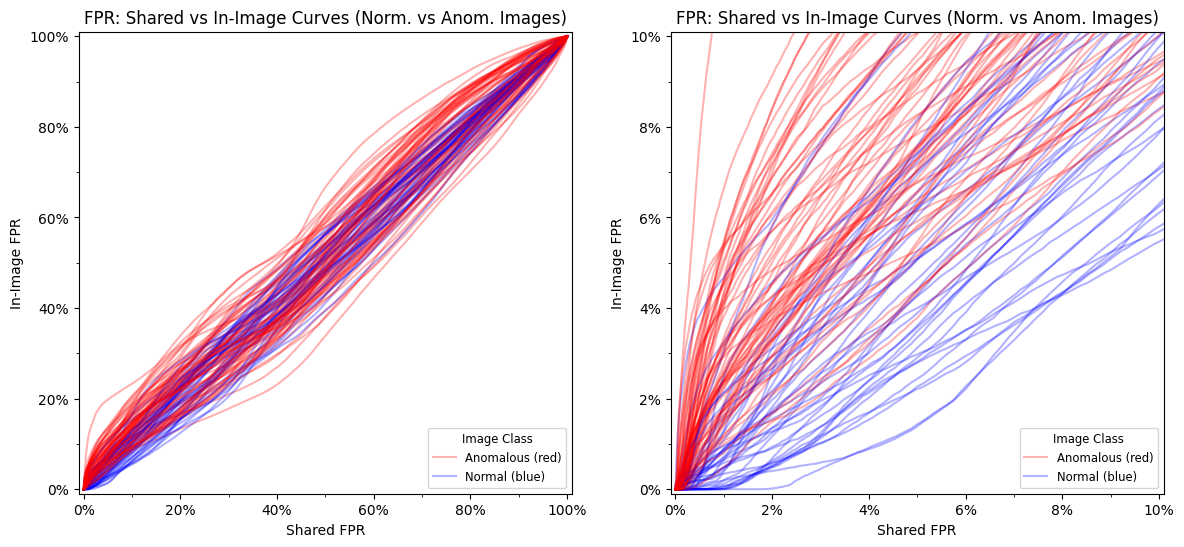

In [20]:
from matplotlib import pyplot as plt
from anomalib.utils.metrics.perimg.plot import plot_pimfpr_curves_norm_vs_anom, _format_axis_rate_metric_linear

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

_ = plot_pimfpr_curves_norm_vs_anom(fprs, shared_fpr, image_classes, ax=axes[0])

# zoom in the lower left corner (low-FPR region)
_ = plot_pimfpr_curves_norm_vs_anom(fprs, shared_fpr, image_classes, ax=axes[1])
_format_axis_rate_metric_linear(axes[1], axis=0, lims=(0, 0.10))
_format_axis_rate_metric_linear(axes[1], axis=1, lims=(0, 0.10))

This difference of FPR behaviour in normal/anomalous images is also an inherent issue with anomaly annotations, which are not always precise or clearly defined.

While using only the normal images to define the x-axis, `PImO` avoids imprecisions in the annotations masks.

Besides, this makes the X and Y axes in `PImO` to be completely data-independent: the X-axis only uses normal images, and the Y-axis only uses anomalous images.

## FPR: Per-Image FPR statistics

> Each line bellow corresponds to the FPR in a single image.
> 
> For a given anomaly score threshold, the x-axis value is the mean in-image FPR only considering the normal images (as in `PImO`), and the y-axis is the value in each of the image (one curve per image; only normal).

Below we show only the FPR curves from normal images and statistics from them.

The y-value on a statistic statistic line is computed based on the collection of FPR values at a given (fixed) anomaly score threshold.

The `mean` curve is the identity curve because the shared FPR here is defined from that metric.

The Standard Error of the Mean (SEM) is computed considering the in-image FPR a random variable normally distributed.

---

**Weakness (but also strength)**

This reveals an inherent weakness of this approach: the x-axis -- which is the reference metric (used to index thresholds) -- naturally shows some uncertainty.

However, this will further punish models with more severe worst case scenarios (i.e. with high FPR on normal images). 

As some images have outlier-high FPR, the average is pushed up, which corresponds to deforming/stretching the `PImO` curves to the right, decreasing the `AUPImO` of all anomalous images.

> In the next section, notice from the plot on the right how a single image is stretching the threshold to very high values because their anomaly scores are too high.

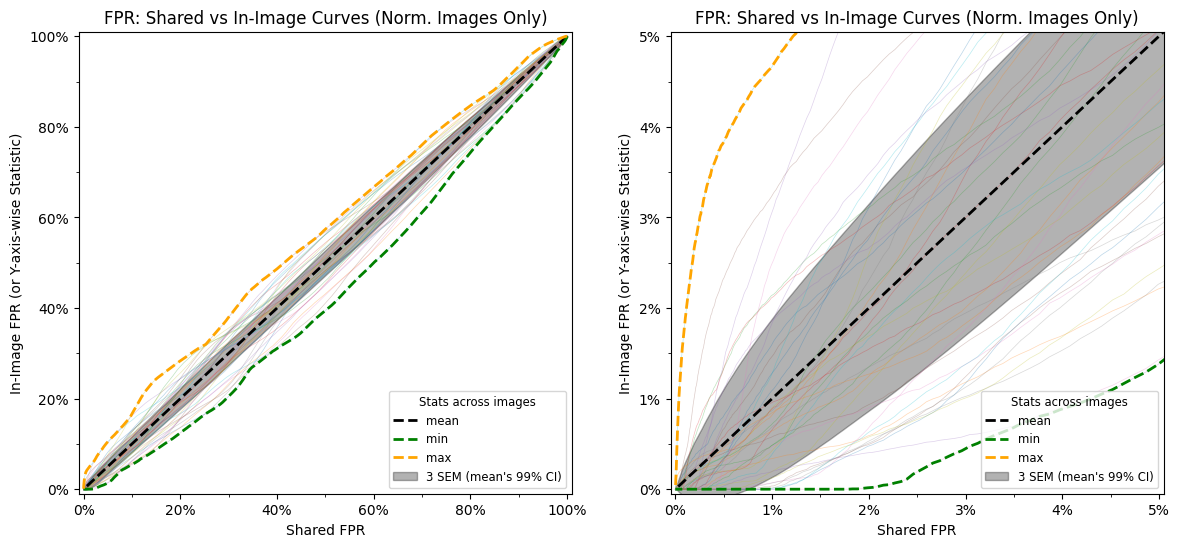

In [21]:
from matplotlib import pyplot as plt

from anomalib.utils.metrics.perimg.plot import plot_pimfpr_curves_norm_only, _format_axis_rate_metric_linear

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

_ = plot_pimfpr_curves_norm_only(fprs, shared_fpr, image_classes, ax=axes[0])

# zoom in the lower left corner (low-FPR region)
_ = plot_pimfpr_curves_norm_only(fprs, shared_fpr, image_classes, ax=axes[1])
_format_axis_rate_metric_linear(axes[1], axis=0, lims=(0, 0.05))
_format_axis_rate_metric_linear(axes[1], axis=1, lims=(0, 0.05))

### max per-image FPR (COMING LATER)

## `fpr_auc_ubound` parameter

The class parameter `fpr_auc_ubound` fixes the upper bound for the shared FPR metric, which corresponds to the lower bound of anomaly score threshold in the range of integration.

This upper bound is choosen is interpreted as the "maximum tolerance of false positives".

The plots below show the per-image FPR vs thresholds (on the right) and vs the shared FPR (on the left), which is there average at each threshold.

In [22]:
%autoreload 2
from anomalib.utils.metrics.perimg import AUPImO
from matplotlib import pyplot as plt
from anomalib.utils.metrics.perimg.plot import _format_axis_rate_metric_linear

# from matplotlib.ticker import FixedLocator
# import numpy as np

aupimo = AUPImO(num_thresholds=1000, ubound=0.03)
aupimo.cpu()
aupimo.update(anomaly_maps, masks)

(_, fprs, shared_fpr, __, image_classes), auc = aupimo.compute()
print(f"{fprs.shape=}\n{shared_fpr.shape=}\n{image_classes.shape=}")

/home/jcasagrandebertoldo/repos/anomalib/src/anomalib/utils/metrics/perimg/binclf_curve.py:350: UserWarning: Metric `AUPImO` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(


AUPImO(ubound=0.03)

fprs.shape=torch.Size([110, 1000])
shared_fpr.shape=torch.Size([1000])
image_classes.shape=torch.Size([110])


(None,
 array([<Axes: title={'center': 'Thresholds vs FPR on Normal Images'}, xlabel='Thresholds', ylabel='False Positive Rate (FPR)'>,
        <Axes: title={'center': 'FPR: Shared vs In-Image Curves (Norm. Images Only)'}, xlabel='Shared FPR', ylabel='In-Image FPR (or Y-axis-wise Statistic)'>],
       dtype=object))

(None,
 array([<Axes: title={'center': 'Thresholds vs FPR on Normal Images'}, xlabel='Thresholds', ylabel='False Positive Rate (FPR)'>,
        <Axes: title={'center': 'FPR: Shared vs In-Image Curves (Norm. Images Only)'}, xlabel='Shared FPR', ylabel='In-Image FPR (or Y-axis-wise Statistic)'>],
       dtype=object))

(10.0, 30.0)

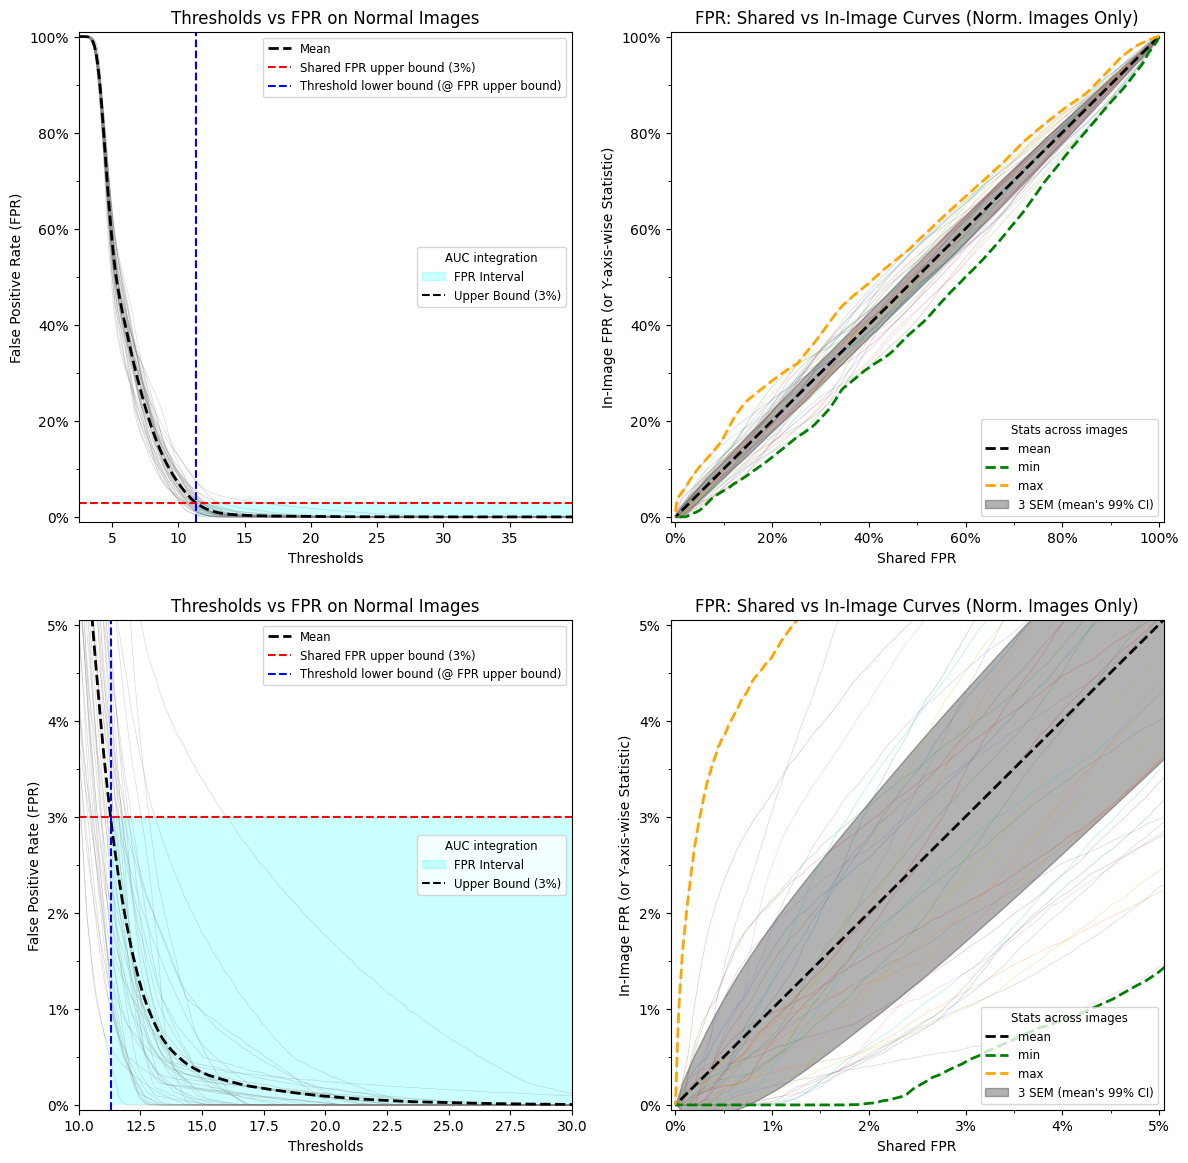

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
aupimo.plot_perimg_fprs(axes=axes[0])

# zoomed in
aupimo.plot_perimg_fprs(axes=axes[1])
_format_axis_rate_metric_linear(axes[1, 1], axis=0, lims=(0, 0.05))
_format_axis_rate_metric_linear(axes[1, 1], axis=1, lims=(0, 0.05))
_format_axis_rate_metric_linear(axes[1, 0], axis=1, lims=(0, 0.05))
axes[1, 0].set_xlim(10, 30)

# scrathc/cache (please ignore this section)

In [24]:
del AUPImO

In [25]:
from pathlib import Path

(CACHE := Path.home() / ".cache").mkdir(exist_ok=True)

In [26]:
torch.save(anomaly_maps, CACHE / "anomaly_maps.pt")
torch.save(masks, CACHE / "masks.pt")

In [27]:
from pathlib import Path

(CACHE := Path.home() / ".cache").mkdir(exist_ok=True)
import torch

anomaly_maps = torch.load(CACHE / "anomaly_maps.pt")
masks = torch.load(CACHE / "masks.pt")

In [28]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
